In [32]:
# import comet_ml at the top of your file
from comet_ml import Experiment
experiment = Experiment(
            project_name="music-genre-multiclass-classification",
            workspace="wodenwang820118",
        )
import comet_ml
import logging

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/737b90dddef04c03ba86fc9fb614c45c



In [33]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger("comet_ml")

In [34]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# the api for grid search the model hyperparameters
from comet_ml import Experiment
import json

os.environ["GRPC_FAIL_FAST"] = "use_caller"
pd.set_option('display.max_columns', None)

In [35]:
# tensorflow 2.7 
import tensorflow as tf 
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model

In [36]:
df_train_features = pd.read_csv('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

df_valid_features = pd.read_csv('valid_features.csv')
df_valid_labels = pd.read_csv('valid_labels.csv')

df_test_features = pd.read_csv('test_features.csv')

In [37]:
def str_remove_comma(string):
    str = string.split(", ")
    return str

def list_to_string(list):
    str = " "
    return str.join(list)

In [38]:
x_train = df_train_features['tags'].apply(lambda x : list_to_string(str_remove_comma(x)))
y_train = df_train_labels['genre'].to_numpy()

x_test = df_valid_features['tags'].apply(lambda x : list_to_string(str_remove_comma(x)))
y_test = df_valid_labels['genre'].to_numpy()

In [39]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [40]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train_labels['genre']),y=df_train_labels['genre'])
class_weight = {i :class_weight[i] for i in range(8)}

In [41]:
import ktrain
from ktrain import text

In [42]:
class TextGenreClassifier:
    def __init__(self,x_train,y_train,x_text,y_text,class_weight,experiment):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_text
        self.y_test = y_text
        self.class_weight = class_weight
        self.experiment = experiment
    
    def build_model(self):
        trn, val, preproc = text.texts_from_array(
            x_train=self.x_train, y_train=self.y_train,
            x_test=self.x_test, y_test=self.y_test,
            class_names = np.unique(df_train_labels['genre']),
            ngram_range=self.experiment.get_parameter("ngram_range"), 
            maxlen=self.experiment.get_parameter("maxlen"), 
            preprocess_mode='standard'
        )
        model = text.text_classifier('nbsvm', train_data=trn, preproc=preproc, metrics=['accuracy'])

        return model, trn, val
    
    def train_model(self):
        # Train the model
        model, trn, val = self.build_model()
        learner = ktrain.get_learner(
            model,
            train_data=trn,
            val_data=val,
            batch_size=self.experiment.get_parameter("batch_size"))
        learner.fit_onecycle(
            lr=0.001,
            epochs=self.experiment.get_parameter("epochs"),
            class_weight=self.class_weight
        )
        return learner, val
    
    def evaluate_model(self):
        # Evaluate the model
        learner, val = self.train_model()
        score = learner.evaluate(test_data=val)
        LOGGER.info(f"{ score }")
    
    def grid_search(self, config_dict):
        opt = comet_ml.Optimizer(config_dict)
        for self.experiment in opt.get_experiments(project_name="music-genre-multiclass-classification"):
            self.build_model()
            self.train_model()
            self.evaluate_model()
            self.experiment.end()

In [43]:
textGenreClassifier = TextGenreClassifier(x_train,y_train,x_test,y_test,class_weight,experiment)

In [44]:
textGenreClassifier.grid_search({
    "algorithm": "bayes",
    "name": "Optimize Music Classification Network",
    "spec": {"maxCombo": 10, "objective": "minimize", "metric": "loss"},
    "parameters": {
        "ngram_range": {"type": "discrete", "values": [1]},
        "maxlen": {"type": "discrete", "values": [150]},
        "epochs": {"type": "discrete", "values": [8,9,10,11]},
        "batch_size": {"type": "discrete", "values": [8,16,32]},
    },
    "trials": 1,
})

COMET INFO: COMET_OPTIMIZER_ID=4ee2cc9feea940f0a54fbe66f1ee8c5c
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 12, 'endTime': None, 'id': '4ee2cc9feea940f0a54fbe66f1ee8c5c', 'lastUpdateTime': None, 'maxCombo': 10, 'name': 'Optimize Music Classification Network', 'parameters': {'batch_size': {'type': 'discrete', 'values': [8, 16, 32]}, 'epochs': {'type': 'discrete', 'values': [8, 9, 10, 11]}, 'maxlen': {'type': 'discrete', 'values': [150]}, 'ngram_range': {'type': 'discrete', 'values': [1]}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 10, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 26900017498, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}
COMET INFO: ---------------------------
COMET INFO: Comet.

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/9
480/480 [==============================] - 3s 6ms/step - loss: 1.8744 - accuracy: 0.3661 - val_loss: 1.5033 - val_accuracy: 0.5467
Epoch 2/9
480/480 [==============================] - 1s 3ms/step - loss: 1.6322 - accuracy: 0.4725 - val_loss: 1.3347 - val_accuracy: 0.5844
Epoch 3/9
480/480 [==============================] - 1s 3ms/step - loss: 1.4701 - accuracy: 0.5188 - val_loss: 1.2643 - val_accuracy: 0.5933
Epoch 4/9
480/480 [==============================] - 1s 3ms/step - loss: 1.3450 - accuracy: 0.5474 - val_loss: 1.2328 - va

COMET INFO: [[ 4  3  5 16  0  4  1 22]
 [ 1  3  8  6  2  6  7 12]
 [ 3  1 42 11  3  1  0  3]
 [ 1  4  7 16  6  5  2  3]
 [ 1  3  4  0 44  6  6  2]
 [ 0  0  0  0  0 74  0  0]
 [ 1  2  2  2  2  0 32  3]
 [ 1  2  3  5  1  2  3 41]]


              precision    recall  f1-score   support

           0       0.33      0.07      0.12        55
           1       0.17      0.07      0.10        45
           2       0.59      0.66      0.62        64
           3       0.29      0.36      0.32        44
           4       0.76      0.67      0.71        66
           5       0.76      1.00      0.86        74
           6       0.63      0.73      0.67        44
           7       0.48      0.71      0.57        58

    accuracy                           0.57       450
   macro avg       0.50      0.53      0.50       450
weighted avg       0.53      0.57      0.53       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/aeabecbd85a748b59f509e3f188fd3e2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [18]                : (0.34084397554397583, 0.6144829392433167)
COMET INFO:     batch_accuracy [864]         : (0.125, 0.8125)
COMET INFO:     batch_loss [864]             : (0.9584271907806396, 3.0141119956970215)
COMET INFO:     epoch_duration [18]          : (1.2819999999992433, 3.0310000000026776)
COMET INFO:     loss [18]                    : (1.0780409574508667, 1.9036492109298706)
COMET INFO:     val_accuracy [18]            : (0.5400000214576721, 0.5933333039283752)
COMET INFO:     val_loss [18]                : (1.2149193286895752, 1.5163872241973877)
COMET INFO:     validate_batch_accur

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/11
480/480 [==============================] - 2s 4ms/step - loss: 1.8824 - accuracy: 0.3322 - val_loss: 1.5221 - val_accuracy: 0.5111
Epoch 2/11
480/480 [==============================] - 1s 3ms/step - loss: 1.6532 - accuracy: 0.4553 - val_loss: 1.3546 - val_accuracy: 0.5733
Epoch 3/11
480/480 [==============================] - 1s 3ms/step - loss: 1.4984 - accuracy: 0.5113 - val_loss: 1.2679 - val_accuracy: 0.5867
Epoch 4/11
480/480 [==============================] - 1s 3ms/step - loss: 1.3765 - accuracy: 0.5405 - val_loss: 1.2295 

COMET INFO: [[ 4  3  5 15  0  5  1 22]
 [ 1  3  8  6  2  6  7 12]
 [ 5  1 41 10  3  1  0  3]
 [ 2  4  7 15  6  4  3  3]
 [ 1  6  4  0 44  5  6  0]
 [ 0  0  0  0  0 74  0  0]
 [ 1  2  2  2  2  0 32  3]
 [ 1  3  3  7  1  2  3 38]]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/ed9aaca6993a463384e68cb19654bfcc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [22]                : (0.32795000076293945, 0.6301119923591614)
COMET INFO:     batch_accuracy [1056]        : (0.14772726595401764, 0.8125)
COMET INFO:     batch_loss [1056]            : (0.7097311019897461, 2.0760719776153564)
COMET INFO:     epoch_duration [22]          : (1.3280000000013388, 2.2810000000026776)
COMET INFO:     loss [22]                    : (1.0301498

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/8
480/480 [==============================] - 3s 6ms/step - loss: 1.8851 - accuracy: 0.3507 - val_loss: 1.5028 - val_accuracy: 0.5222
Epoch 2/8
480/480 [==============================] - 2s 4ms/step - loss: 1.6264 - accuracy: 0.4694 - val_loss: 1.3361 - val_accuracy: 0.5711
Epoch 3/8
480/480 [==============================] - 2s 4ms/st

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/8
480/480 [==============================] - 2s 4ms/step - loss: 1.8680 - accuracy: 0.3474 - val_loss: 1.4979 - val_accuracy: 0.5333
Epoch 2/8
480/480 [==============================] - 2s 5ms/step - loss: 1.6180 - accuracy: 0.4713 - val_loss: 1.3357 - val_accuracy: 0.5978
Epoch 3/8
480/480 [==============================] - 1s 3ms/step - loss: 1.4534 - accuracy: 0.5221 - val_loss: 1.2551 - val_accuracy: 0.6000
Epoch 4/8
480/480 [==============================] - 2s 4ms/step - loss: 1.3268 - accuracy: 0.5524 - val_loss: 1.2234 - val_accuracy: 0.5956
Epoch 5/8
480/480 [==============================] - 1s 3ms/step - loss: 1.2283 - accuracy: 0.5740 - val_loss: 1.2199 - val_accuracy: 0.5778
Epoch 6/8
480/480 [==============================] - 2s 4ms/step - loss: 1.1647 - accuracy: 0.5860 - val_loss: 1.2121 - val_accuracy: 0.5711
Epoch 7/8
480/480 [==============================] - 2s

COMET INFO: [[ 3  4  5 16  0  4  1 22]
 [ 1  3  9  6  2  5  7 12]
 [ 2  1 44 10  4  1  0  2]
 [ 1  4  6 16  7  6  2  2]
 [ 1  3  3  0 44  6  7  2]
 [ 0  0  0  0  0 73  1  0]
 [ 1  2  2  2  2  0 33  2]
 [ 1  2  3  5  1  3  2 41]]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/9d3e0496001148e9913b5c79e08389b1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [16]                : (0.34735608100891113, 0.6041938066482544)
COMET INFO:     batch_accuracy [768]         : (0.125, 0.75)
COMET INFO:     batch_loss [768]             : (1.0352727174758911, 2.403183698654175)
COMET INFO:     epoch_duration [16]          : (1.2810000000026776, 2.936999999998079)
COMET INFO:     loss [16]                    : (1.1076984405517578, 1.88511

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/9
240/240 [==============================] - 3s 10ms/step - loss: 1.9335 - accuracy: 0.3360 - val_loss: 1.6096 - val_accuracy: 0.4889
Epoch 2/9
240/240 [==============================] - 2s 8ms/step - loss: 1.6935 - accuracy: 0.4538 - val_loss: 1.4077 - val_accuracy: 0.5511
Epoch 3/9
240/240 [==============================] - 1s 5ms/step - loss: 1.5450 - accuracy: 0.4960 - val_loss: 1.3156 - val_accuracy: 0.5844
Epoch 4/9
240/240 [==============================] - 2s 7ms/step - loss: 1.4256 - accuracy: 0.5264 - val_loss: 1.2611 - v

COMET INFO: [[ 3  3  7 16  0  2  1 23]
 [ 0  3 10  5  2  6  6 13]
 [ 2  1 43 10  5  1  0  2]
 [ 1  1  8 17  6  6  3  2]
 [ 1  3  3  0 46  6  5  2]
 [ 0  0  0  0  0 74  0  0]
 [ 0  2  3  1  2  0 33  3]
 [ 1  1  3  5  1  3  2 42]]
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/7e552f99ed674fca923ac6d766cbc241
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [18]                : (0.3116697072982788, 0.5927324891090393)
COMET INFO:     batch_accuracy [432]         : (0.09375, 0.6875)
COMET INFO:     batch_loss [432]             : (0.9175338745117188, 2.408168315887451)
COMET INFO:     epoch_duration [18]          : (0.875, 2.9060000000026776)
COMET INFO:     loss [18]                    : (1.1654733419418335, 1.94924688339233

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/8
960/960 [==============================] - 11s 11ms/step - loss: 1.8358 - accuracy: 0.3688 - val_loss: 1.4436 - val_accuracy: 0.5467
Epoch 2/8
960/960 [==============================] - 10s 11ms/step - loss: 1.5594 - accuracy: 0.4909 - val_los

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/8
960/960 [==============================] - 11s 11ms/step - loss: 1.8352 - accuracy: 0.3833 - val_loss: 1.4386 - val_accuracy: 0.5533
Epoch 2/8
960/960 [==============================] - 10s 10ms/step - loss: 1.5537 - accuracy: 0.4940 - val_loss: 1.2871 - val_accuracy: 0.5867
Epoch 3/8
960/960 [==============================] - 10s 10ms/step - loss: 1.3773 - accuracy: 0.5439 - val_loss: 1.2288 - val_accuracy: 0.5889
Epoch 4/8
960/960 [==============================] - 10s 11ms/step - loss: 1.2474 - accuracy: 0.5675 - val_loss: 1.2150 - val_accuracy: 0.5733
Epoch 5/8
960/960 [==============================] - 7s 7ms/step - loss: 1.1481 - accuracy: 0.5918 - val_loss: 1.2090 - val_accuracy: 0.5778
Epoch 6/8
960/960 [==============================] - 4s 4ms/step - loss: 1.0823 - accuracy: 0.6098 - val_loss: 1.2217 - val_accuracy: 0.5600
Epoch 7/8
960/960 [============================

COMET INFO: [[ 4  3  5 15  0  6  1 21]
 [ 1  3  8  6  1  9  7 10]
 [ 4  1 40 11  4  1  0  3]
 [ 2  4  7 14  7  5  2  3]
 [ 1  6  4  0 44  4  7  0]
 [ 0  0  0  0  0 73  1  0]
 [ 1  2  2  3  2  0 31  3]
 [ 1  3  3  7  1  2  3 38]]


              precision    recall  f1-score   support

           0       0.29      0.07      0.12        55
           1       0.14      0.07      0.09        45
           2       0.58      0.62      0.60        64
           3       0.25      0.32      0.28        44
           4       0.75      0.67      0.70        66
           5       0.73      0.99      0.84        74
           6       0.60      0.70      0.65        44
           7       0.49      0.66      0.56        58

    accuracy                           0.55       450
   macro avg       0.48      0.51      0.48       450
weighted avg       0.51      0.55      0.51       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/30bb2c5186344e1c993ded2f958a7db9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [16]                : (0.36884605884552, 0.6306329965591431)
COMET INFO:     batch_accuracy [1536]        : (0.125, 1.0)
COMET INFO:     batch_loss [1536]            : (0.7793060541152954, 2.3630645275115967)
COMET INFO:     epoch_duration [16]          : (3.610000000000582, 10.625)
COMET INFO:     loss [16]                    : (1.0230273008346558, 1.8357616662979126)
COMET INFO:     val_accuracy [16]            : (0.54666668176651, 0.5911111235618591)
COMET INFO:     val_loss [16]                : (1.2090415954589844, 1.4435937404632568)
COMET INFO:     validate_batch_accuracy [96] : (0.375, 0.

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/9
960/960 [==============================] - 9s 9ms/step - loss: 1.8603 - accuracy: 0.3743 - val_loss: 1.4632 - val_accuracy: 0.5511
Epoch 2/9
960/960 [==============================] - 4s 4ms/step - loss: 1.5790 - accuracy: 0.4762 - val_loss: 1.3086 - val_accuracy: 0.6044
Epoch 3/9
960/960 [==============================] - 4s 4ms/st

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/9
960/960 [==============================] - 3s 3ms/step - loss: 1.8259 - accuracy: 0.3784 - val_loss: 1.4395 - val_accuracy: 0.5489
Epoch 2/9
960/960 [==============================] - 3s 3ms/step - loss: 1.5687 - accuracy: 0.4872 - val_loss: 1.2988 - val_accuracy: 0.5778
Epoch 3/9
960/960 [==============================] - 3s 3ms/step - loss: 1.3961 - accuracy: 0.5301 - val_loss: 1.2422 - val_accuracy: 0.5822
Epoch 4/9
960/960 [==============================] - 3s 3ms/step - loss: 1.2671 - accuracy: 0.5646 - val_loss: 1.2180 - va

COMET INFO: [[ 4  3  5 16  0  6  1 20]
 [ 1  3  8  6  1 10  7  9]
 [ 5  1 40 10  4  1  0  3]
 [ 3  4  5 16  7  3  2  4]
 [ 1  6  4  0 44  5  6  0]
 [ 0  0  0  0  0 73  1  0]
 [ 1  2  2  3  2  0 31  3]
 [ 1  3  3  6  1  2  3 39]]


              precision    recall  f1-score   support

           0       0.25      0.07      0.11        55
           1       0.14      0.07      0.09        45
           2       0.60      0.62      0.61        64
           3       0.28      0.36      0.32        44
           4       0.75      0.67      0.70        66
           5       0.73      0.99      0.84        74
           6       0.61      0.70      0.65        44
           7       0.50      0.67      0.57        58

    accuracy                           0.56       450
   macro avg       0.48      0.52      0.49       450
weighted avg       0.51      0.56      0.52       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/a209acbdf97949f89cfb129941f96a50
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [18]                 : (0.3743162155151367, 0.6401406526565552)
COMET INFO:     batch_accuracy [1728]         : (0.125, 1.0)
COMET INFO:     batch_loss [1728]             : (0.5164788961410522, 2.376208782196045)
COMET INFO:     epoch_duration [18]           : (2.6560000000026776, 8.796999999998661)
COMET INFO:     loss [18]                     : (0.9958898425102234, 1.8602776527404785)
COMET INFO:     val_accuracy [18]             : (0.5488888621330261, 0.6044444441795349)
COMET INFO:     val_loss [18]                 : (1.209072232246399, 1.463248610496521)
COMET INFO:     validate_batch_accura

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/11
960/960 [==============================] - 4s 4ms/step - loss: 1.8420 - accuracy: 0.3747 - val_loss: 1.4671 - val_accuracy: 0.5333
Epoch 2/11
960/960 [==============================] - 3s 4ms/step - loss: 1.5912 - accuracy: 0.4807 - val_loss: 1.3051 - val_accuracy: 0.5956
Epoch 3/11
960/960 [==============================] - 3s 4ms/step - loss: 1.4255 - accuracy: 0.5294 - val_loss: 1.2411 - val_accuracy: 0.5800
Epoch 4/11
960/960 [==============================] - 3s 4ms/step - loss: 1.2995 - accuracy: 0.5557 - val_loss: 1.2168 - val_accuracy: 0.5911
Epoch 5/11
960/960 [==============================] - 3s 4ms/step - loss: 1.1996 - accuracy: 0.5794 - val_loss: 1.2017 - val_accuracy: 0.5867
Epoch 6/11
960/960 [==============================] - 3s 4ms/step - loss: 1.1179 - accuracy: 0.5965 - val_loss: 1.2116 - val_accuracy: 0.5689
Epoch 7/11
960/960 [=============================

COMET INFO: [[ 4  3  5 15  0  7  1 20]
 [ 0  5  7  6  1 10  7  9]
 [ 6  1 39  9  5  1  0  3]
 [ 2  4  5 17  6  4  2  4]
 [ 2  6  4  0 42  5  7  0]
 [ 0  0  0  0  0 72  2  0]
 [ 1  2  2  3  2  2 30  2]
 [ 1  3  3  7  1  2  3 38]]


              precision    recall  f1-score   support

           0       0.25      0.07      0.11        55
           1       0.21      0.11      0.14        45
           2       0.60      0.61      0.60        64
           3       0.30      0.39      0.34        44
           4       0.74      0.64      0.68        66
           5       0.70      0.97      0.81        74
           6       0.58      0.68      0.62        44
           7       0.50      0.66      0.57        58

    accuracy                           0.55       450
   macro avg       0.48      0.52      0.49       450
weighted avg       0.51      0.55      0.52       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/3ed418bf8a1047b0a0731e9cab2efe71
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [22]                 : (0.3571242392063141, 0.6512112617492676)
COMET INFO:     batch_accuracy [2112]         : (0.16532258689403534, 1.0)
COMET INFO:     batch_loss [2112]             : (0.7552825212478638, 2.566906213760376)
COMET INFO:     epoch_duration [22]           : (3.3280000000013388, 3.9530000000013388)
COMET INFO:     loss [22]                     : (0.951273500919342, 1.8568252325057983)
COMET INFO:     val_accuracy [22]             : (0.5333333611488342, 0.602222204208374)
COMET INFO:     val_loss [22]                 : (1.2016838788986206, 1.4670593738555908)
COMET INFO:     valida

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/8
240/240 [==============================] - 1s 5ms/step - loss: 1.8927 - accuracy: 0.3311 - val_loss: 1.5493 - val_accuracy: 0.5089
Epoch 2/8
240/240 [==============================] - 1s 4ms/step - loss: 1.6852 - accuracy: 0.4483 - val_loss: 1.3734 - val_accuracy: 0.5689
Epoch 3/8
240/240 [==============================] - 1s 4ms/step - loss: 1.5309 - accuracy: 0.4962 - val_loss: 1.2898 - val_accuracy: 0.5956
Epoch 4/8
240/240 [==============================] - 1s 4ms/step - loss: 1.4065 - accuracy: 0.5336 - val_loss: 1.2472 - va

COMET INFO: [[ 3  3  7 16  0  2  1 23]
 [ 0  1 11  6  2  7  5 13]
 [ 0  0 45 11  5  0  0  3]
 [ 1  4  9 16  7  3  2  2]
 [ 1  4  3  0 46  5  5  2]
 [ 0  0  0  0  0 74  0  0]
 [ 0  1  2  2  2  0 35  2]
 [ 1  1  3  4  1  2  2 44]]


              precision    recall  f1-score   support

           0       0.50      0.05      0.10        55
           1       0.07      0.02      0.03        45
           2       0.56      0.70      0.62        64
           3       0.29      0.36      0.32        44
           4       0.73      0.70      0.71        66
           5       0.80      1.00      0.89        74
           6       0.70      0.80      0.74        44
           7       0.49      0.76      0.60        58

    accuracy                           0.59       450
   macro avg       0.52      0.55      0.50       450
weighted avg       0.55      0.59      0.54       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/41d868bbbdbc4fde953b906cac84f11a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [16]                : (0.3310757875442505, 0.5855691432952881)
COMET INFO:     batch_accuracy [384]         : (0.15625, 0.71875)
COMET INFO:     batch_loss [384]             : (0.9097651243209839, 2.3208110332489014)
COMET INFO:     epoch_duration [16]          : (0.8280000000013388, 1.4059999999954016)
COMET INFO:     loss [16]                    : (1.1924649477005005, 1.9033044576644897)
COMET INFO:     val_accuracy [16]            : (0.5088889002799988, 0.5955555438995361)
COMET INFO:     val_loss [16]                : (1.2095346450805664, 1.549403429031372)
COMET INFO:     validate_batch_accu

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/10
960/960 [==============================] - 3s 3ms/step - loss: 1.8384 - accuracy: 0.3586 - val_loss: 1.4615 - val_accuracy: 0.5400
Epoch 2/10
960/960 [==============================] - 3s 3ms/step - loss: 1.5829 - accuracy: 0.4786 - val_loss: 1.3083 - val_accuracy: 0.5889
Epoch 3/10
960/960 [==============================] - 3s 3ms/step - loss: 1.4116 - accuracy: 0.5283 - val_loss: 1.2469 - val_accuracy: 0.5800
Epoch 4/10
960/960 [==============================] - 3s 3ms/step - loss: 1.2838 - accuracy: 0.5602 - val_loss: 1.2086 - val_accuracy: 0.5867
Epoch 5/10
960/960 [==============================] - 3s 3ms/step - loss: 1.1819 - accuracy: 0.5793 - val_loss: 1.2590 - val_accuracy: 0.5600
Epoch 6/10
960/960 [==============================] - 3s 3ms/step - loss: 1.1016 - accuracy: 0.6037 - val_loss: 1.2394 - val_accuracy: 0.5556
Epoch 7/10
960/960 [=============================

COMET INFO: [[ 5  3  4 15  0  7  1 20]
 [ 1  4  8  6  1  9  7  9]
 [ 6  1 39  9  5  1  0  3]
 [ 2  4  5 16  7  3  3  4]
 [ 1  6  4  0 44  5  6  0]
 [ 0  0  0  0  0 73  1  0]
 [ 1  2  2  3  2  2 30  2]
 [ 1  3  3  6  1  2  3 39]]


              precision    recall  f1-score   support

           0       0.29      0.09      0.14        55
           1       0.17      0.09      0.12        45
           2       0.60      0.61      0.60        64
           3       0.29      0.36      0.32        44
           4       0.73      0.67      0.70        66
           5       0.72      0.99      0.83        74
           6       0.59      0.68      0.63        44
           7       0.51      0.67      0.58        58

    accuracy                           0.56       450
   macro avg       0.49      0.52      0.49       450
weighted avg       0.52      0.56      0.52       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/6c87f748690c459895d52b458dfbd261
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [20]                 : (0.35855692625045776, 0.6449596285820007)
COMET INFO:     batch_accuracy [1920]         : (0.0, 0.875)
COMET INFO:     batch_loss [1920]             : (0.7269760370254517, 2.4091172218322754)
COMET INFO:     epoch_duration [20]           : (2.6089999999967404, 9.18699999999808)
COMET INFO:     loss [20]                     : (0.9720174670219421, 1.8503860235214233)
COMET INFO:     val_accuracy [20]             : (0.5400000214576721, 0.5933333039283752)
COMET INFO:     val_loss [20]                 : (1.208624243736267, 1.4614750146865845)
COMET INFO:     validate_batch_accu

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/10
240/240 [==============================] - 2s 7ms/step - loss: 1.9167 - accuracy: 0.3277 - val_loss: 1.5705 - val_accuracy: 0.5267
Epoch 2/10
240/240 [==============================] - 3s 14ms/step - loss: 1.7029 - accuracy: 0.4454 - val_loss: 1.3899 - val_accuracy: 0.5667
Epoch 3/10
240/240 [==============================] - 3s 12ms/step - loss: 1.5583 - accuracy: 0.4918 - val_loss: 1.3083 - val_accuracy: 0.5778
Epoch 4/10
240/240 [==============================] - 3s 13ms/step - loss: 1.4407 - accuracy: 0.5247 - val_loss: 1.25

COMET INFO: [[ 4  3  5 16  0  4  1 22]
 [ 0  3  8  7  2  6  7 12]
 [ 2  1 44 11  3  0  0  3]
 [ 1  4  9 17  6  3  2  2]
 [ 1  4  2  0 46  5  6  2]
 [ 0  0  0  0  0 74  0  0]
 [ 0  2  2  2  2  0 33  3]
 [ 1  1  3  4  1  3  2 43]]


              precision    recall  f1-score   support

           0       0.44      0.07      0.12        55
           1       0.17      0.07      0.10        45
           2       0.60      0.69      0.64        64
           3       0.30      0.39      0.34        44
           4       0.77      0.70      0.73        66
           5       0.78      1.00      0.88        74
           6       0.65      0.75      0.69        44
           7       0.49      0.74      0.59        58

    accuracy                           0.59       450
   macro avg       0.52      0.55      0.51       450
weighted avg       0.55      0.59      0.54       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/fca20699d34d47fb9c55a4deda549430
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [20]                : (0.3276894986629486, 0.5970304608345032)
COMET INFO:     batch_accuracy [480]         : (0.125, 0.6875)
COMET INFO:     batch_loss [480]             : (0.9605534672737122, 2.1322851181030273)
COMET INFO:     epoch_duration [20]          : (0.7350000000005821, 3.4530000000013388)
COMET INFO:     loss [20]                    : (1.139471173286438, 1.918200969696045)
COMET INFO:     val_accuracy [20]            : (0.5199999809265137, 0.6000000238418579)
COMET INFO:     val_loss [20]                : (1.209211826324463, 1.579359531402588)
COMET INFO:     validate_batch_accuracy [

In [72]:
trn2, val2, preproc2 = text.texts_from_array(
    x_train=x_train, y_train=y_train,
    x_test=x_test, y_test=y_test,
    ngram_range=1, 
    maxlen=150,
    class_names = np.unique(df_train_labels['genre']),
    preprocess_mode='standard'
)

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


In [73]:
model2 = text.text_classifier('nbsvm', train_data=trn2, preproc=preproc2, metrics=['accuracy'])

Is Multi-Label? False
compiling word ID features...
maxlen is 150
building document-term matrix... this may take a few moments...
rows: 1-7678
computing log-count ratios...
done.


In [74]:
learner = ktrain.get_learner(model2, train_data=trn2, val_data=val2, batch_size=32)

In [75]:
learner.fit_onecycle(lr=0.001,epochs=10, class_weight=class_weight)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/10
240/240 [==============================] - 1s 3ms/step - loss: 1.9245 - accuracy: 0.3108 - val_loss: 1.5948 - val_accuracy: 0.5000
Epoch 2/10
240/240 [==============================] - 1s 2ms/step - loss: 1.7108 - accuracy: 0.4401 - val_loss: 1.4113 - val_accuracy: 0.5667
Epoch 3/10
240/240 [==============================] - 1s 2ms/step - loss: 1.5630 - accuracy: 0.4885 - val_loss: 1.3296 - val_accuracy: 0.5933
Epoch 4/10
240/240 [==============================] - 1s 2ms/step - loss: 1.4434 - accuracy: 0.5268 - val_loss: 1.2755 - val_accuracy: 0.5978
Epoch 5/10
240/240 [==============================] - 1s 3ms/step - loss: 1.3453 - accuracy: 0.5469 - val_loss: 1.2456 - val_accuracy: 0.5933
Epoch 6/10
240/240 [==============================] - 1s 3ms/step - loss: 1.2651 - accuracy: 0.5675 - val_loss: 1.2115 - val_accuracy: 0.5889
Epoch 7/10
240/240 [==============================] - 1s 3ms/step - loss: 1.2101 - ac

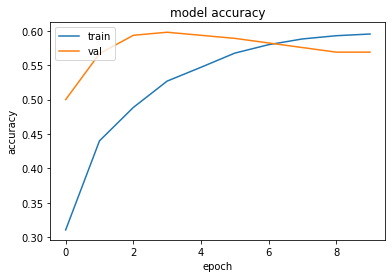

In [76]:
plt.plot(learner.history.history['accuracy'])
plt.plot(learner.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

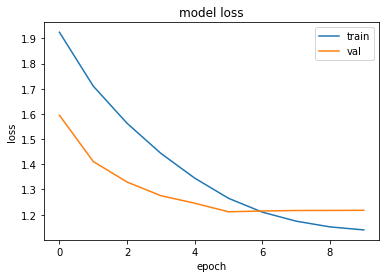

In [77]:
plt.plot(learner.history.history['loss'])
plt.plot(learner.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [78]:
learner.evaluate()

              precision    recall  f1-score   support

           0       0.38      0.05      0.10        55
           1       0.16      0.07      0.09        45
           2       0.58      0.67      0.62        64
           3       0.27      0.34      0.30        44
           4       0.75      0.67      0.70        66
           5       0.75      1.00      0.86        74
           6       0.65      0.75      0.69        44
           7       0.49      0.71      0.58        58

    accuracy                           0.57       450
   macro avg       0.50      0.53      0.49       450
weighted avg       0.53      0.57      0.53       450



array([[ 3,  3,  5, 16,  0,  4,  1, 23],
       [ 0,  3,  9,  7,  2,  6,  7, 11],
       [ 2,  1, 43, 11,  3,  1,  0,  3],
       [ 1,  4,  8, 15,  7,  5,  2,  2],
       [ 1,  4,  4,  0, 44,  5,  6,  2],
       [ 0,  0,  0,  0,  0, 74,  0,  0],
       [ 0,  2,  2,  3,  2,  0, 33,  2],
       [ 1,  2,  3,  4,  1,  4,  2, 41]], dtype=int64)

In [79]:
predictor = ktrain.get_predictor(model2, preproc=preproc2)
predictor.save('text_only_nbsvm')